# Imports and downloads

In [ ]:
import tensorflow as tf
import pandas
import numpy as np
import librosa
import os

import matplotlib.pyplot

from tensorflow import keras
from sklearn.model_selection import train_test_split
from typing import Union, Tuple
from google.colab import files
from IPython.display import Audio

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
!pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=b9a53fb5b361c6ee512820a9623722b09bb55705763928f74f66fa88b4d994dc
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"warriormachine","key":"73711ef14c6810e273077de6f28901ae"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
  
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s "CommonVoice Langage"
!kaggle datasets download -d olmatz/commonvoice-langage
!unzip commonvoice-langage.zip
!rm -rf commonvoice-langage.zip
!rm -rf "dataset/train/chinese"
!rm -rf "dataset/train/german"
!rm -rf "dataset/train/italian"
!rm -rf "dataset/train/spanish"
!rm -rf "dataset/validation/chinese"
!rm -rf "dataset/validation/german"
!rm -rf "dataset/validation/italian"
!rm -rf "dataset/validation/spanish"

# Spectrogram

In [ ]:
import librosa as lr
import warnings
import matplotlib.pyplot as plt
import imageio
from glob import glob

sample_rate = 8000
image_width = 500
image_height = 256
batch_size = 128

dataset_root_path = '/content/dataset/'
audio_file = '/content/dataset/train/english/0000a1804c153bbb8cc5360a0b59a4818e7b4639e8948794af5eb2f725bf9c6219d4da66c0ee1bcd911295f87d33fab29165049095de65542efbb1165d33999f_0.wav'

In [ ]:
train = 'train'
test = 'validation'

eng = 'english'
fr = 'french'

languages = [eng, fr]
categories = [train, test]

In [ ]:
def load_audio_file(audio_file_path):
    warnings.simplefilter('ignore', UserWarning)
    
    audio_segment, _ = lr.load(audio_file_path, sr=sample_rate)
    return audio_segment

    warnings.simplefilter('default', UserWarning)

def spectrogram(audio_segment):
    # Compute mel-scaled spectrogram image
    hl = audio_segment.shape[0] // image_width
    spec = lr.feature.melspectrogram(audio_segment, n_mels=image_height, hop_length=int(hl))

    # Logarithmic amplitudes
    image = lr.core.power_to_db(spec)

    # Convert to numpy matrix
    image_np = np.asmatrix(image)

    # Normalize and scale
    image_np_scaled_temp = (image_np - np.min(image_np))
    
    image_np_scaled = image_np_scaled_temp / np.max(image_np_scaled_temp)

    return image_np_scaled[:, 0:image_width]

def to_integer(image_float):
    # range (0,1) -> (0,255)
    image_float_255 = image_float * 255.
    
    # Convert to uint8 in range [0:255]
    image_int = image_float_255.astype(np.uint8)
    
    return image_int

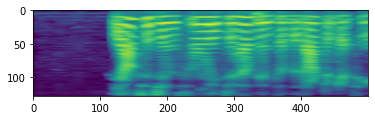

In [ ]:
sp = spectrogram(load_audio_file(audio_file))
sp.shape
plt.imshow(sp)

In [ ]:
audio_files = {}

for category in categories:
    for lang in languages:
        dataset_path = dataset_root_path + category + '/' + lang
        
        # If you wish to preprocess all data use the following command
        audio_files[category + '.' + lang] = glob(dataset_path + '/*.wav')

print(audio_files.keys())

dict_keys(['train.english', 'train.french', 'validation.english', 'validation.french'])


In [ ]:
def audio_to_image_file(audio_file):
    out_image_file = audio_file + '.png'
    audio = load_audio_file(audio_file)
    if np.count_nonzero(audio) != 0:
        spectro = spectrogram(audio)
        spectro_int = to_integer(spectro)
        imageio.imwrite(out_image_file, spectro_int)
    else:
        print('WARNING! Detected an empty audio signal. Skipping...')

In [ ]:
for category in categories:
    for lang in languages:
        all_audio_files = audio_files[category + '.' + lang]
        
        num_files = len(all_audio_files)

        for i in range(num_files):
            if i % 100 == 0:
                print('Still processing ' + lang + ' ' + category + ' ' + str(i) + '/' + str(num_files))
            audio_to_image_file(all_audio_files[i])

/content/dataset/train/english/0c661276da840245310d0b7d9c23250f3f8fe4d31a0cfbab8ffca18b58356ea2ce9df03e3984c86c0a23ae93ce8b500da5b18a98a0370dae88a3bf62a8ab0ccf_0.wav.png


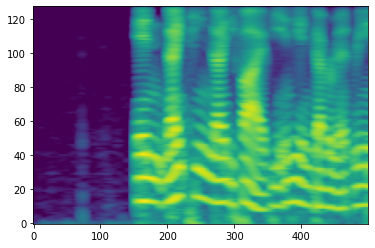

In [ ]:
list_of_image_files = glob(dataset_root_path + train + '/' + eng + '/*.png')
image_file_path = list_of_image_files[0]

print(image_file_path)

image = imageio.imread(image_file_path)

plt.imshow(image, origin='lower', aspect='auto')
plt.show()

In [ ]:
audio_file_path = os.path.splitext(image_file_path)[0]

Audio(audio_file_path)

# Model

In [ ]:
validation_split = 0.1
initial_learning_rate = 0.045
train_path = dataset_root_path + train

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [ ]:
from glob import glob
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 197
Validation steps: 21


In [ ]:
image_data_generator = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='binary', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='binary', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 25233 images belonging to 2 classes.
Found 2803 images belonging to 2 classes.


In [ ]:
from keras import layers, models

In [ ]:
keras.backend.clear_session()

In [ ]:
input_shape = image.shape
print(input_shape)

In [ ]:
img_input = Input(shape=(image_height, image_width, 1))
img_conc = Concatenate(axis=3, name='input_concat')([img_input])
img_input, img_conc

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,Dense, Dropout

In [ ]:
base_model = InceptionV3(input_shape = (image_width,image_height,1), input_tensor=img_conc, weights=None, include_top=False,) # input shape sus

In [ ]:
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(1, activation='sigmoid')(out)
predictions

In [ ]:
model = keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [ ]:
loss = 'binary_crossentropy'
metrics = ['accuracy']
model.compile(loss=loss, metrics=metrics) 

In [ ]:
EPOCHS = 40
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=EPOCHS, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=validation_steps, 
                    callbacks=[early_stopping])

Epoch 1/40
197/197 [==============================] - 277s 1s/step - loss: 0.6278 - accuracy: 0.6773 - val_loss: 1.4445 - val_accuracy: 0.4981
Epoch 2/40
197/197 [==============================] - 242s 1s/step - loss: 0.3837 - accuracy: 0.8310 - val_loss: 2.4047 - val_accuracy: 0.5774
Epoch 3/40
197/197 [==============================] - 242s 1s/step - loss: 0.2871 - accuracy: 0.8805 - val_loss: 3.9406 - val_accuracy: 0.5580
Epoch 4/40
197/197 [==============================] - 242s 1s/step - loss: 0.2220 - accuracy: 0.9089 - val_loss: 0.3528 - val_accuracy: 0.8512
Epoch 5/40
197/197 [==============================] - 242s 1s/step - loss: 0.1822 - accuracy: 0.9271 - val_loss: 0.3816 - val_accuracy: 0.8590
Epoch 6/40
197/197 [==============================] - 242s 1s/step - loss: 0.1481 - accuracy: 0.9417 - val_loss: 1.1234 - val_accuracy: 0.7954
Epoch 7/40
197/197 [==============================] - 242s 1s/step - loss: 0.1226 - accuracy: 0.9530 - val_loss: 0.2212 - val_accuracy: 0.9237

In [ ]:
model_file = 'model.h5'

In [ ]:
keras.models.save_model(model, '/content/model.h5')


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpoj86n7ln/assets


INFO:tensorflow:Assets written to: /tmp/tmpoj86n7ln/assets


92370064

# Model performance

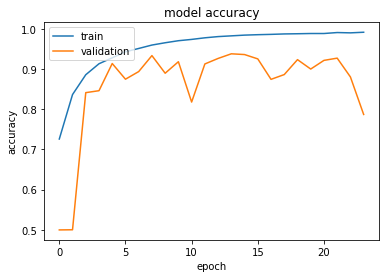

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

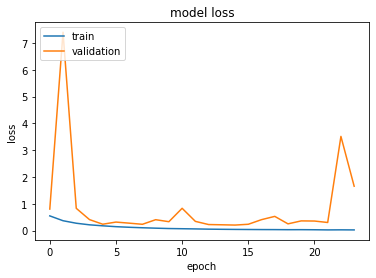

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_path = dataset_root_path + test
test_path

'/content/dataset/validation'

In [ ]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 54


In [ ]:
image_data_generator = ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='binary', target_size=(image_height, image_width), color_mode='grayscale')

Found 7010 images belonging to 2 classes.


In [ ]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

54/54 [==============================] - 17s 319ms/step - loss: 0.8035 - accuracy: 0.8597


In [ ]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 86.0 %
